In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
import os
from PIL import Image
data_dir='/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data'
class ImageDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for loading and preprocessing images.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        
        self.image_paths = []
        self.classes=[]
        for sub in os.listdir(root_dir):
            self.classes = list(set(self.classes + [item for item in os.listdir(root_dir + '/' + sub)]))

        for sub in os.listdir(root_dir):
            self.image_paths+=self.get_pathes(root_dir+'/'+sub)
        
        self.class_to_idx = {label: i for i, label in enumerate(self.classes)}
        self.transform = transform

    def get_pathes(self, root):
        image_paths = []
        labels = os.listdir(root)

        for label in labels:
            images = os.listdir(os.path.join(root, label))    
            image_paths.extend([os.path.join(root, label, image) for image in images])
        return image_paths

    def __len__(self):
        """
        Returns the number of images in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Loads and preprocesses an image at a given index.

        Args:
          idx (int): Index of the image to return.

        Returns:
          tuple: A tuple containing the preprocessed image and its label (if available).
        """
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Assuming RGB images
        if self.transform:
            image = self.transform(image)

        # Add logic to load labels if available (modify based on your data structure)
        label_name = os.path.normpath(image_path).split(os.path.sep)[-2]

        return image, self.class_to_idx[label_name]


In [4]:
custom_train_data = ImageDataset(data_dir)

custom_train_data.classes

['all', 'hem']

In [5]:
from torch.utils.data import random_split

train_size = int(0.8 * len(custom_train_data))
test_size = len(custom_train_data) - train_size

train_data, test_data = random_split(custom_train_data, [train_size, test_size])

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


train_data = TransformDataset(train_data, transform = train_transform)
test_data = TransformDataset(test_data, transform = test_transform)

In [7]:
from torch import nn
import torch.nn.functional as F
import numpy as np
from torchvision import models


class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Використання ResNet-50 замість VGG
        resnet = models.resnet50(pretrained=True)
        
        # Від'єднання градієнтів для усіх параметрів, крім останнього шару
        for param in resnet.parameters():
            param.requires_grad = False
        
        # Кількість нейронів на виході останнього шару перед класифікатором
        in_features = resnet.fc.in_features
        
        # Заміна останнього повнозв'язного шару на Identity, щоб використати наш шар
        resnet.fc = nn.Identity()
        
        # Ініціалізація модулів
        self.feature_extractor = resnet
        
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(in_features, num_classes)
        

    def forward(self, x):
        # Отримання ознак з feature extractor
        out = self.feature_extractor(x)  # out має розмір (batch_size, in_features)
        
        out = self.dropout(out)
        out = self.linear(out)
        
        return out


    def predict(self, X, device='cpu'):
        # Перетворення вхідних даних у тензор та перенесення на вказаний пристрій
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


# Ініціалізація моделі з кількістю класів, наприклад, для класифікації видів лейкемії
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransferLearningClassifier(num_classes=len(['hem', 'all'])).to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s] 


In [8]:
!pip install -q torchsummary

In [9]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [11]:
# Визначення функції втрат та оптимізатора

loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [13]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TransferLearningClassifier, opt=Adam(lr=0.001000), epochs=20, device=cuda

Epoch    1  265sec	loss:      0.502	val_loss:      0.444	accuracy_score:      0.766	val_accuracy_score:      0.818	
Epoch    2   97sec	loss:       0.43	val_loss:      0.416	accuracy_score:      0.815	val_accuracy_score:      0.829	
Epoch    3   98sec	loss:      0.416	val_loss:      0.461	accuracy_score:      0.827	val_accuracy_score:      0.807	
Epoch    4   98sec	loss:      0.408	val_loss:        0.4	accuracy_score:      0.824	val_accuracy_score:      0.844	
Epoch    5   96sec	loss:      0.401	val_loss:      0.388	accuracy_score:      0.834	val_accuracy_score:      0.843	
Epoch    6   96sec	loss:      0.401	val_loss:      0.414	accuracy_score:      0.835	val_accuracy_score:      0.833	
Epoch    7   96sec	loss:        0.4	val_loss:      0.404	accuracy_score:       0.83	val_accuracy_score:      0.837	
Epoch    8   97sec	loss:      0.384	val_loss:      0.412	accuracy_score:      0.839	val_acc

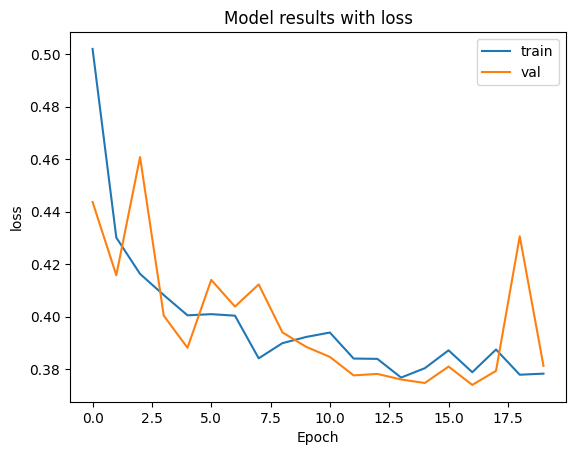

In [15]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

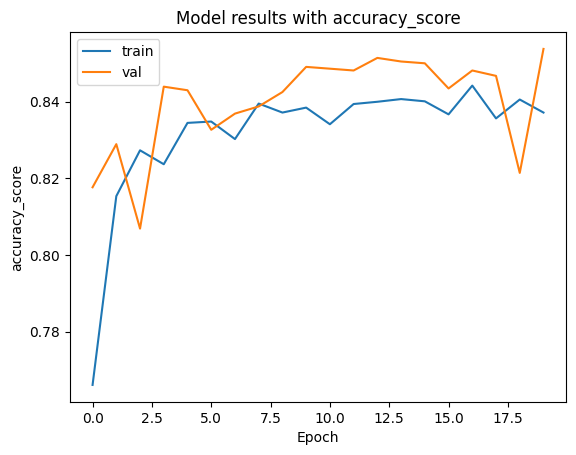

In [16]:
plot_metric(history, 'accuracy_score')

In [20]:

from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # переключаем модель на использование ЦП
model.eval()

batch_size = 1024 
loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

y_true = []
y_pred = []

for X_batch, y_batch in loader:
    batch_pred = model.predict(X_batch)
    
    y_true.extend(y_batch.tolist())
    y_pred.extend(batch_pred.argmax(-1).tolist())

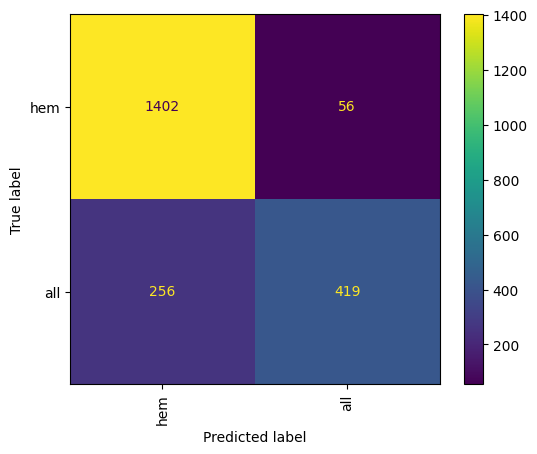

In [21]:
display_labels = ['hem', 'all']

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=display_labels)
plt.xticks(rotation=90)
plt.show()